In [ ]:
import pandas as pd
import json

df = pd.read_csv(
    '/media/ys_tum/T7 Shield/25SS/SDI_data/tennis.csv',
    # '/media/ys_tum/T7 Shield/25SS/SDI_data/uefa_0603.csv'
    dtype={
        'coordinates': str,
        'location': str,
        'text': str,
        'created_at': str,
        'lang': str,
        'hashTags': str
    }
)
df

,coordinates,location,text,created_at,lang,hashTags
0,NaN,London. The greatest city,I totally expected #Venus to dominate this #Wi...,Sat Jul 15 14:18:55 +0000 2017,en,Venus Wimbledon tennis Muguruza
1,NaN,"City of Light - Paris, France",@GarbiMuguruza is on 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥...,Sat Jul 15 14:19:00 +0000 2017,en,Wimbledon2017 Wimbledon TeamGarbiñe
2,NaN,NaN,What superb tennis. Incredible backhands !! E...,Sat Jul 15 14:19:06 +0000 2017,en,Muguruza Wimbeldon2017
3,NaN,"Alicante, Comunidad Valenciana",Alucinando como se está moviendo Garbiñe por l...,Sat Jul 15 14:19:06 +0000 2017,es,VamosGarbiñe Wimbledon
4,NaN,Madrid,Vamos Muguruza queda poco! #WimbledonMovistar,Sat Jul 15 14:19:08 +0000 2017,es,WimbledonMovistar
...,...,...,...,...,...,...
15420,NaN,México City,@gonzalezsanty y Scott Lipsky avanzan a la 2da...,Tue Jul 18 23:30:09 +0000 2017,es,Newport ATP Tennis
15421,NaN,Ig: lola.bcr,Le tennis ou courir https://t.co/Z5tNx4tOyy,Tue Jul 18 23:30:33 +0000 2017,fr,NaN
15422,NaN,London (exiled to York),My friend is sitting beside me trying to have ...,Tue Jul 18 23:31:28 +0000 2017,en,youseemyproblem
15423,NaN,München-Hamburg-Paris-London,@BPedrettiLeS @Bayernismo T'es le seul gamin à...,Tue Jul 18 23:54:05 +0000 2017,fr,NaN


<Axes: >

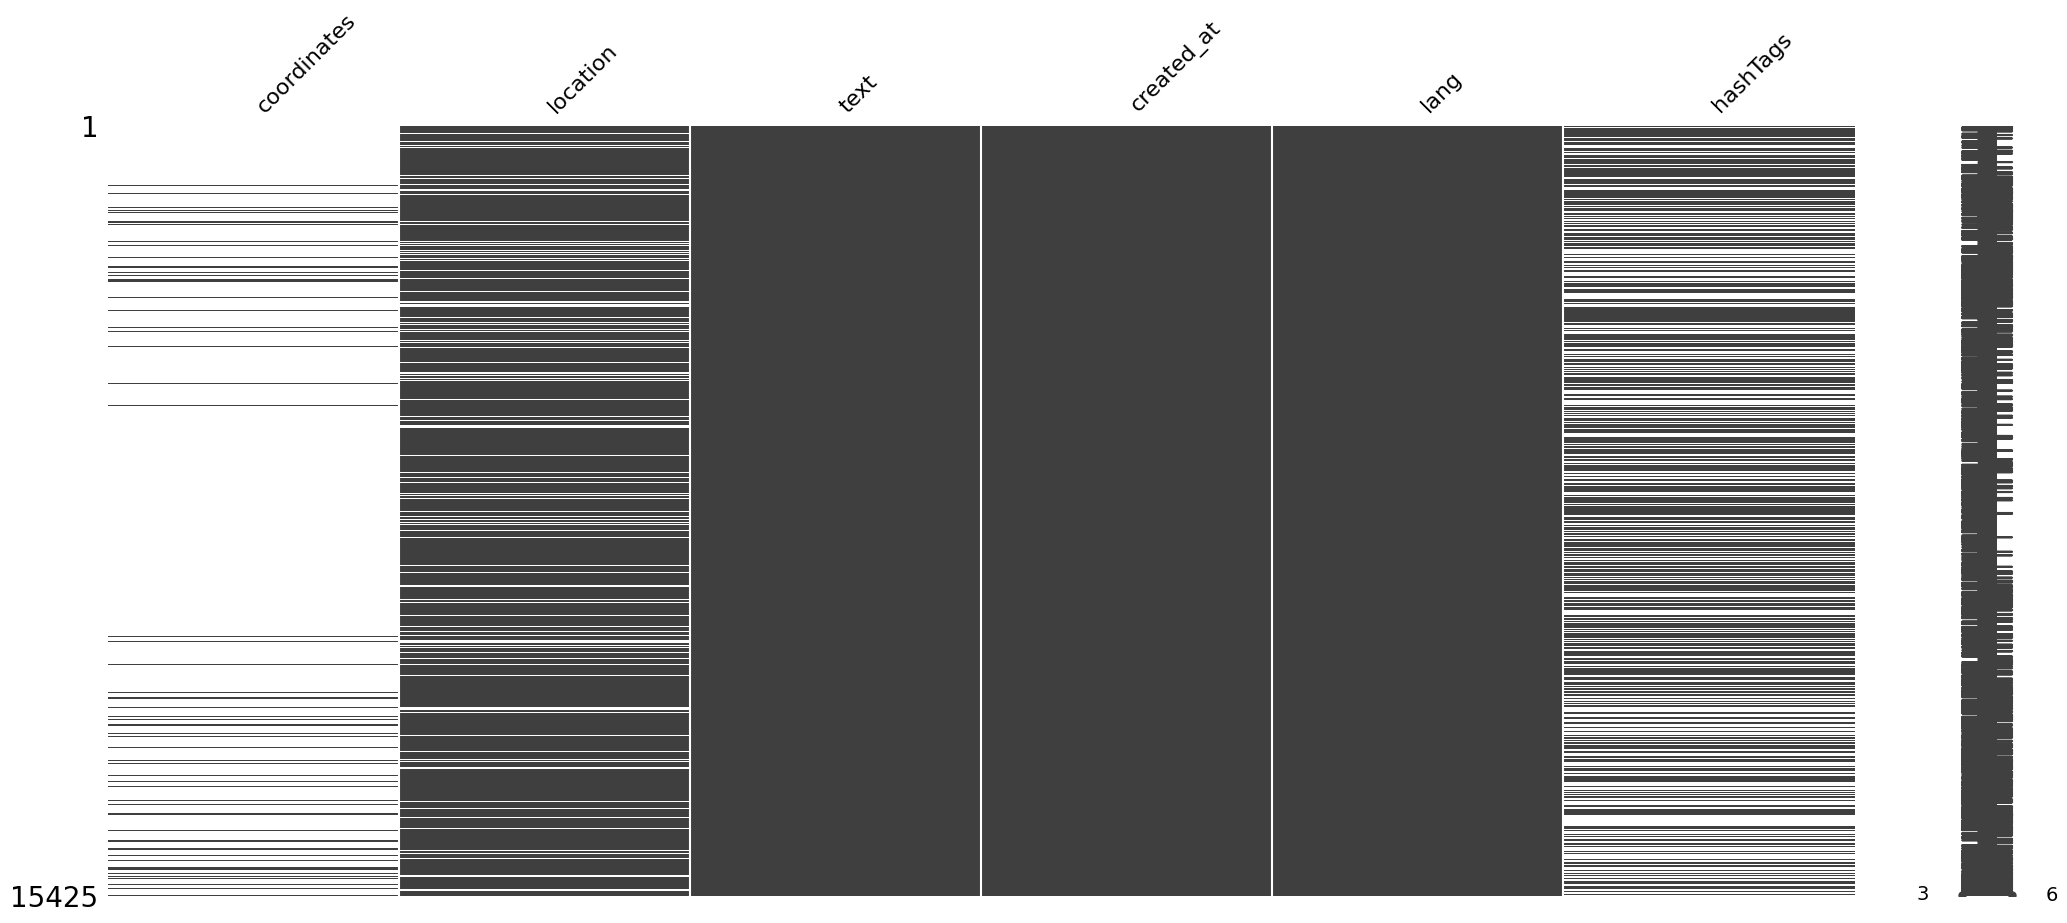

In [2]:
# 查看缺失值
import missingno as msno
  
# Visualize missing values as a matrix
msno.matrix(df)

## Deal with Brexit Tweet
Filter based on hastags and text

                    coordinates                     location  \
280     53.36853317,-6.28034668      Americas | UK | Ireland   
929                         NaN               United Kingdom   
1483                        NaN  Colchester, East Anglia, UK   
1823                        NaN                          NaN   
2165    53.36853317,-6.28034668      Americas | UK | Ireland   
...                         ...                          ...   
272740                      NaN                  northampton   
273988                      NaN     Scotland, United Kingdom   
274735                      NaN    Hanson Regan ; London, UK   
274764                      NaN     University of Nottingham   
275437                      NaN                          NaN   

                                                     text  \
280     MWIE —  Ireland is in prime position to profit...   
929     Elephant in the room for Corbyn is his brexit ...   
1483    May appeals to voters to let her 'fulfil

<Axes: >

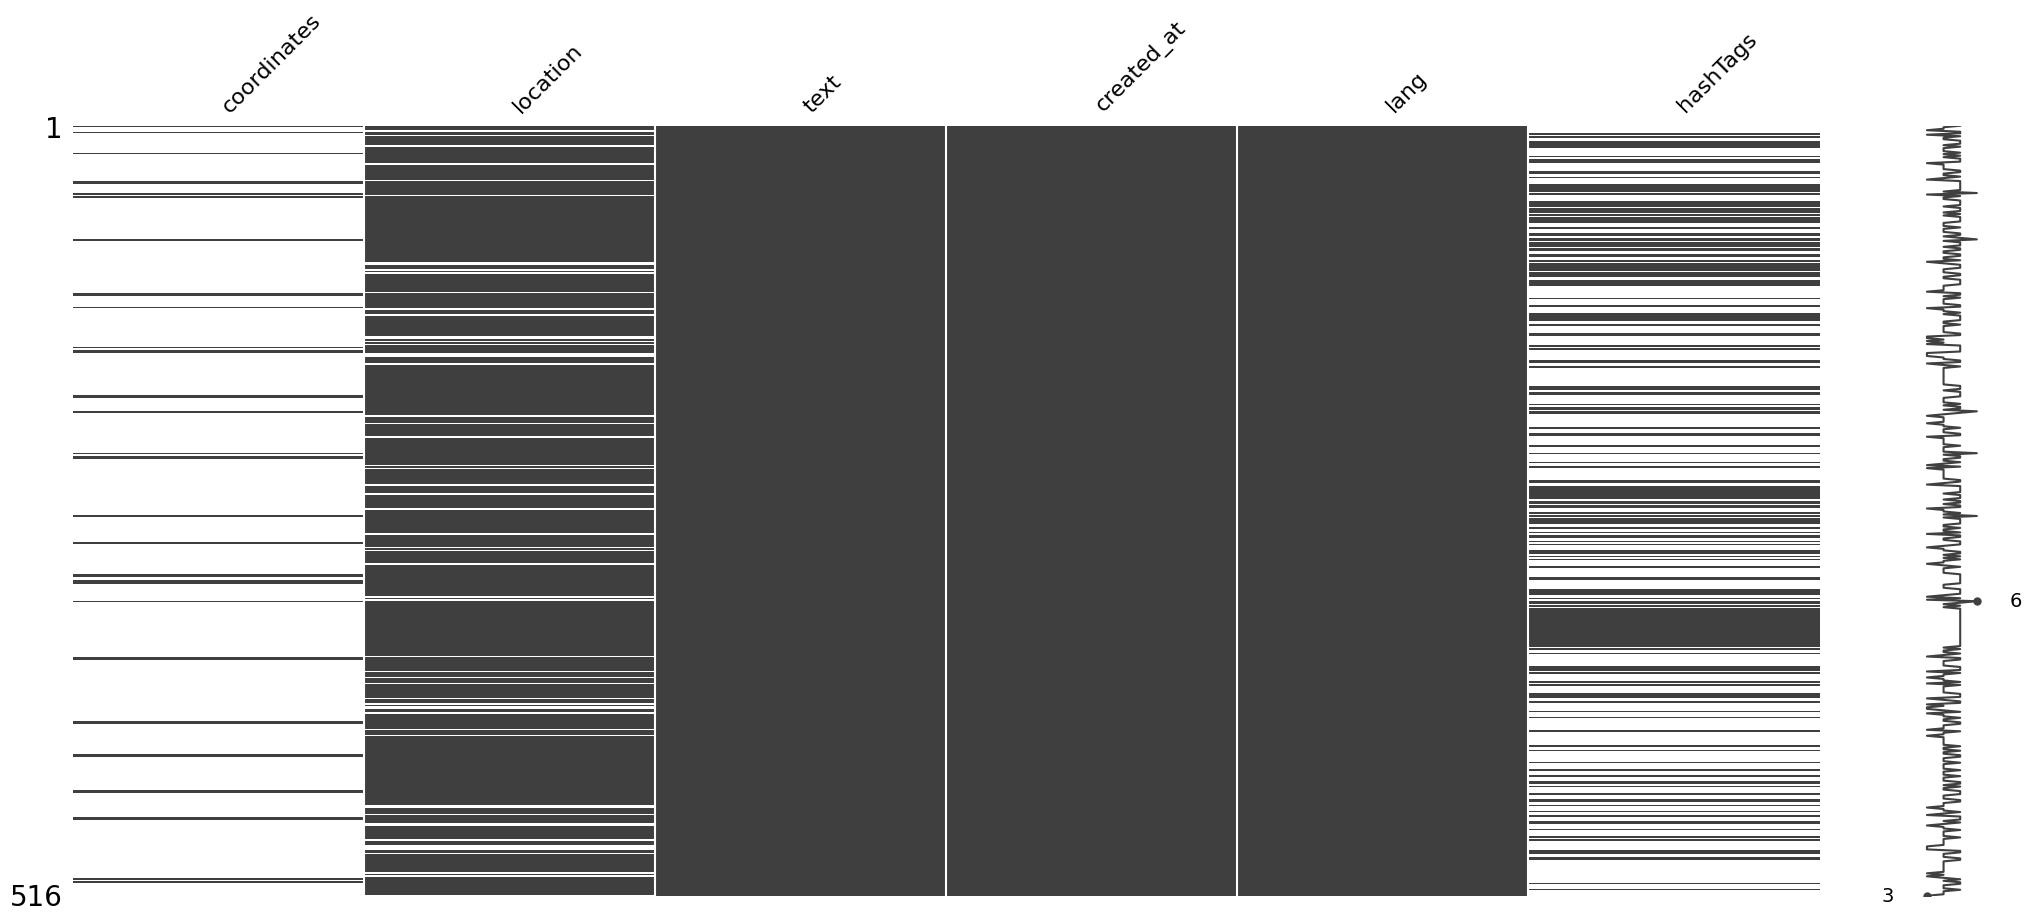

In [3]:
mask = (
    df['hashTags'].str.contains('brexit', case=False, na=False)
    | df['text'].str.contains('brexit', case=False, na=False)
)
new_df = df[mask]
print(new_df)
msno.matrix(new_df)

## Deal with the UEFA in 2017.06.03

1. Check if with geolocations
2. Check if related with uefa
3. Check if is en, translate to english

### clean the data according to locations

=== 推文位置数据清洗报告 ===
总推文数: 15,425
保留推文数: 11,955
删除推文数: 3,470
删除比例: 22.50%

删除原因分布:
  : 2,094 (13.6%)
  multiple_countries: 1,112 (7.2%)
  junk_location: 187 (1.2%)
  contains_emoji: 77 (0.5%)


<Axes: >

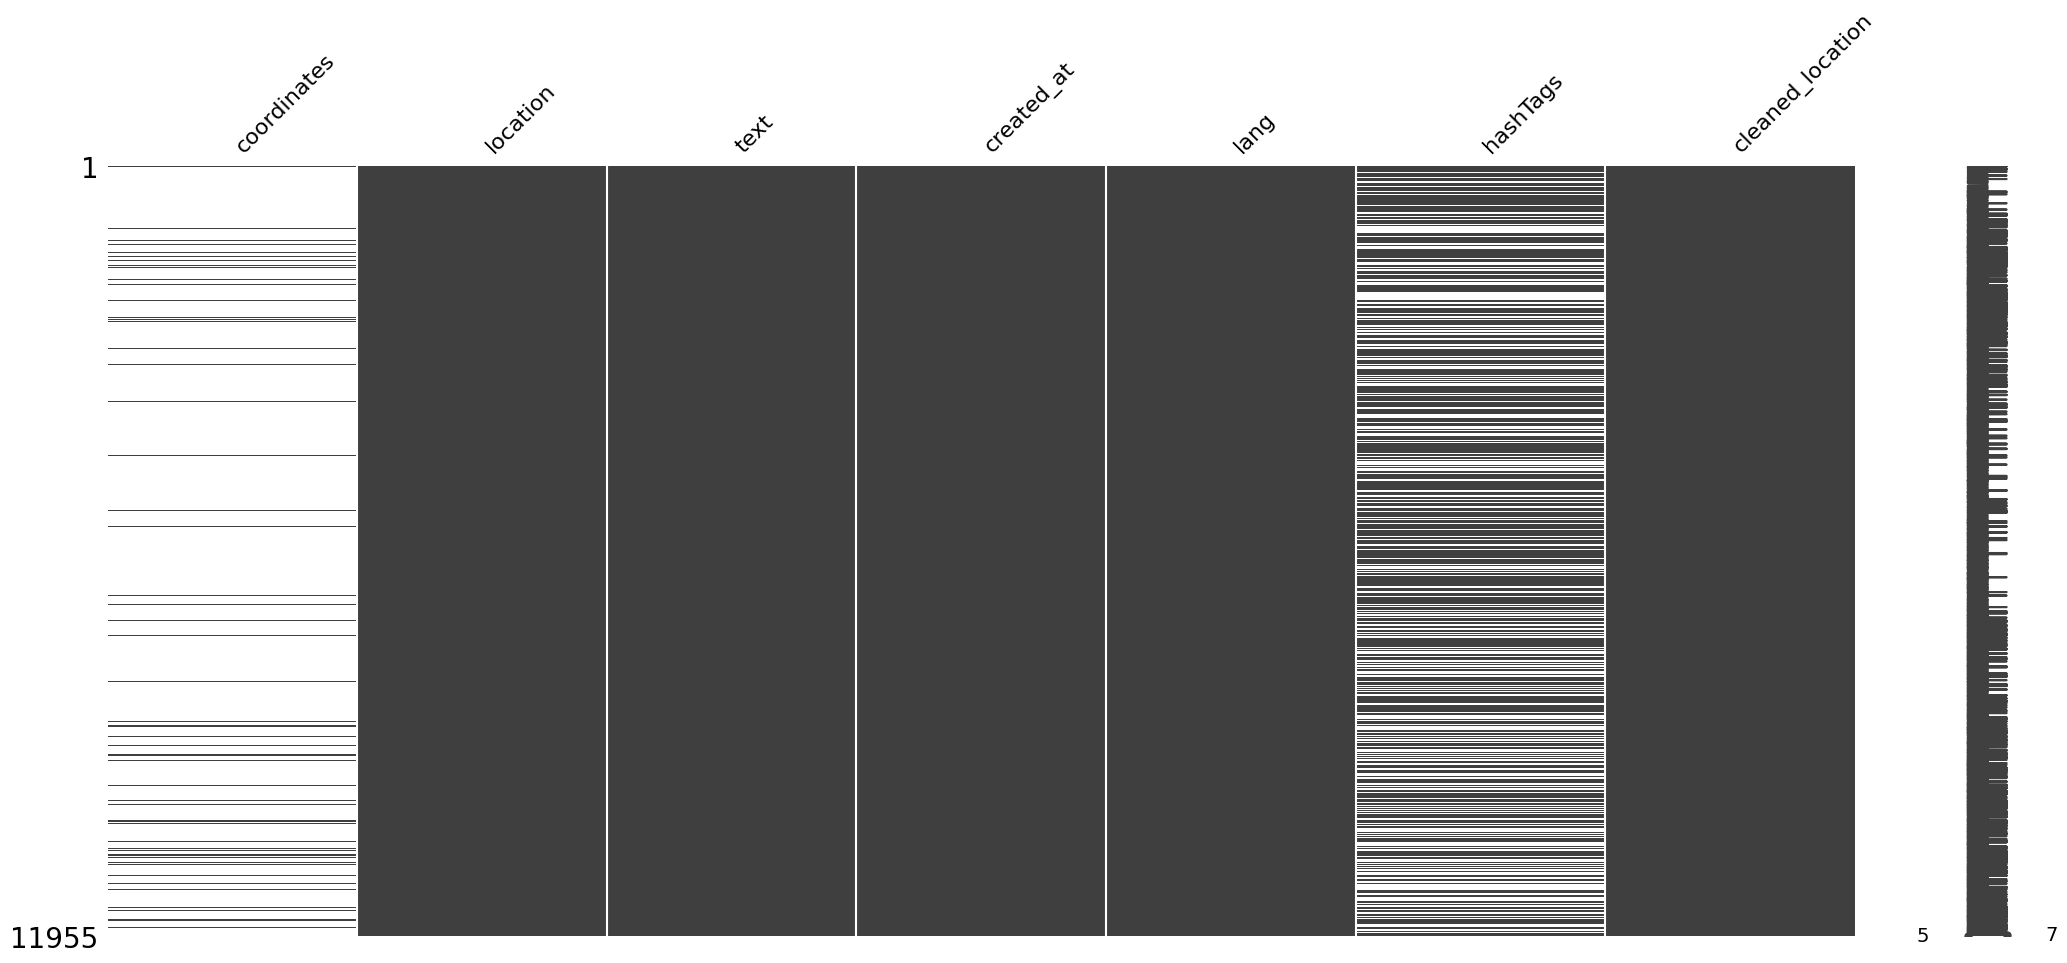

In [3]:
import re
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional

class TweetLocationCleaner:
    def __init__(self):
        self.junk_patterns = [
            r'^[0-9\s\-\+\(\)]+$',  # 纯数字和符号
            r'^[a-zA-Z]{1,2}$',     # 1-2个字母
            r'^[\.\,\;\!\?\*\-\+\=\s]+$',  # 纯标点符号
            r'^[qwertyuiop]+$|^[asdfghjkl]+$|^[zxcvbnm]+$',  # 键盘乱打
        ]
        
        self.virtual_locations = {
            'internet', 'cyberspace', 'online', 'web', 'cloud',
            'everywhere', 'nowhere', 'somewhere', 'anywhere',
            'your heart', 'your mind', 'your dreams', 'heaven', 'hell',
            'wonderland', 'neverland', 'atlantis', 'narnia',
            'following you', 'behind you', 'ask me', 'guess',
            'classified', 'secret', 'unknown', 'mystery'
        }
        
        self.broad_locations = {
            'europe', 'asia', 'africa', 'america', 'oceania',
            'north', 'south', 'east', 'west', 'northern', 'southern',
            'eastern', 'western', 'worldwide', 'global', 'international'
        }
        self.valid_european_locations = {
            'countries': {
                'uk', 'united kingdom', 'england', 'scotland', 'wales', 'ireland',
                'france', 'germany', 'spain', 'italy', 'portugal', 'netherlands',
                'belgium', 'sweden', 'norway', 'denmark', 'finland', 'austria',
                'switzerland', 'poland', 'czech republic', 'hungary', 'greece'
            },
            'cities': {
                'london', 'paris', 'berlin', 'madrid', 'rome', 'amsterdam',
                'barcelona', 'munich', 'vienna', 'zurich', 'stockholm',
                'copenhagen', 'oslo', 'helsinki', 'prague', 'budapest',
                'athens', 'lisbon', 'dublin', 'edinburgh', 'milan', 'naples'
            }
        }
    
    def has_emoji(self, text) -> bool:
        """检测文本是否包含表情符号"""
        if not isinstance(text, str):
            return False
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "]+", 
            flags=re.UNICODE
        )
        return bool(emoji_pattern.search(text))
    
    def has_multiple_countries(self, text: str) -> bool:
        """检测是否包含多个国家"""
        text_lower = text.lower()
        country_count = sum(1 for country in self.valid_european_locations['countries'] 
                           if country in text_lower)
        
        # 检查分隔符模式，如 "A, B", "A/B", "A-B"
        separators = [',', '/', '-', '&', 'and', '|', ';']
        has_separator = any(sep in text for sep in separators)
        
        return country_count > 1 or (country_count >= 1 and has_separator and len(text.split()) > 2)
    
    def is_junk_location(self, location: str) -> bool:
        """判断是否为垃圾位置"""
        if not location or not location.strip():
            return True
            
        location_clean = location.strip().lower()
        for pattern in self.junk_patterns:
            if re.match(pattern, location_clean):
                return True
        if location_clean in self.virtual_locations:
            return True
        if location_clean in self.broad_locations:
            return True
            
        return False
    
    def clean_location_text(self, location: str) -> str:
        """清洗位置文本"""
        if not location:
            return ""
        # 去除多余空格和换行
        location = re.sub(r'\s+', ' ', location.strip())
        
        # 移除特殊字符前后的空格
        location = re.sub(r'\s*([,;])\s*', r'\1 ', location)
        return location
    
    def classify_tweet_location(self, row: pd.Series) -> Dict:
        """对单条推文的位置信息进行分类"""
        location = row.get('location', '')
        
        result = {
            'keep': False,
            'reason': '',
            'cleaned_location': '',
            'has_coordinates': False
        }
        
        # 检查坐标
        has_coords = not (pd.isna("coordinates"))
        result['has_coordinates'] = has_coords
        

        # 情况1: 完全无位置信息
        if not isinstance(location, str) and not has_coords:
            result['reason'] = 'no_location_info'
            return result
        
        # 情况3: 有location但是垃圾数据
        if isinstance(location, str):
            if self.has_emoji(location):
                result['reason'] = 'contains_emoji'
                return result
            
            if self.has_multiple_countries(location):
                result['reason'] = 'multiple_countries'
                return result
                
            if self.is_junk_location(location):
                result['reason'] = 'junk_location'
                return result
        
        # 通过所有检查，保留这条数据
            result['keep'] = True
            result['cleaned_location'] = self.clean_location_text(location)
            result['reason'] = 'valid'
        
        return result
    
    def clean_dataframe(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """清洗整个数据框"""
        results = []
        stats = {
            'total': len(df),
            'kept': 0,
            'removed_reasons': {}
        }
        
        for idx, row in df.iterrows():
            classification = self.classify_tweet_location(row)
            results.append(classification)
            
            if classification['keep']:
                stats['kept'] += 1
            else:
                reason = classification['reason']
                stats['removed_reasons'][reason] = stats['removed_reasons'].get(reason, 0) + 1
        
        # 创建结果数据框
        results_df = pd.DataFrame(results)
        clean_df = df[results_df['keep']].copy()
        clean_df['cleaned_location'] = results_df[results_df['keep']]['cleaned_location'].values
        
        # 添加统计信息
        stats['removal_rate'] = (stats['total'] - stats['kept']) / stats['total']
        
        return clean_df, stats
    
    def print_cleaning_report(self, stats: Dict):
        """打印清洗报告"""
        print("=== 推文位置数据清洗报告 ===")
        print(f"总推文数: {stats['total']:,}")
        print(f"保留推文数: {stats['kept']:,}")
        print(f"删除推文数: {stats['total'] - stats['kept']:,}")
        print(f"删除比例: {stats['removal_rate']:.2%}")
        print("\n删除原因分布:")
        
        for reason, count in sorted(stats['removed_reasons'].items(), 
                                  key=lambda x: x[1], reverse=True):
            percentage = count / stats['total'] * 100
            print(f"  {reason}: {count:,} ({percentage:.1f}%)")



cleaner = TweetLocationCleaner()
clean_df, stats = cleaner.clean_dataframe(df)
    
# 打印报告
cleaner.print_cleaning_report(stats)
clean_df
msno.matrix(clean_df)

## more filter based on keywords

In [4]:
def is_champions_league_related(text):
    if pd.isna(text):
            return False
    text_lower = text.lower()
    return any(keyword.lower() in text_lower for keyword in champions_league_keywords)

    # Step 3: Check if tweets are related to Champions League
champions_league_keywords =  [
        "Champions League", "UCL", "CL final", "Cardiff final",
        "Real Madrid", "Juventus", "Juve", 
        "Ronaldo", "Zidane", "Buffon", 
        "#RMJUV", "#UCLfinal", "#UCL", "#ChampionsLeague"
    ]
    
    
    # Check in both original text and translated text
clean_df['is_cl_related'] = df.apply(
        lambda row: is_champions_league_related(row['text']) or 
                   is_champions_league_related(row['hashTags']),
        axis=1
    )
    
    # Final filter for Champions League related tweets
clean_df = clean_df[clean_df['is_cl_related']].reset_index(drop=True)

<Axes: >

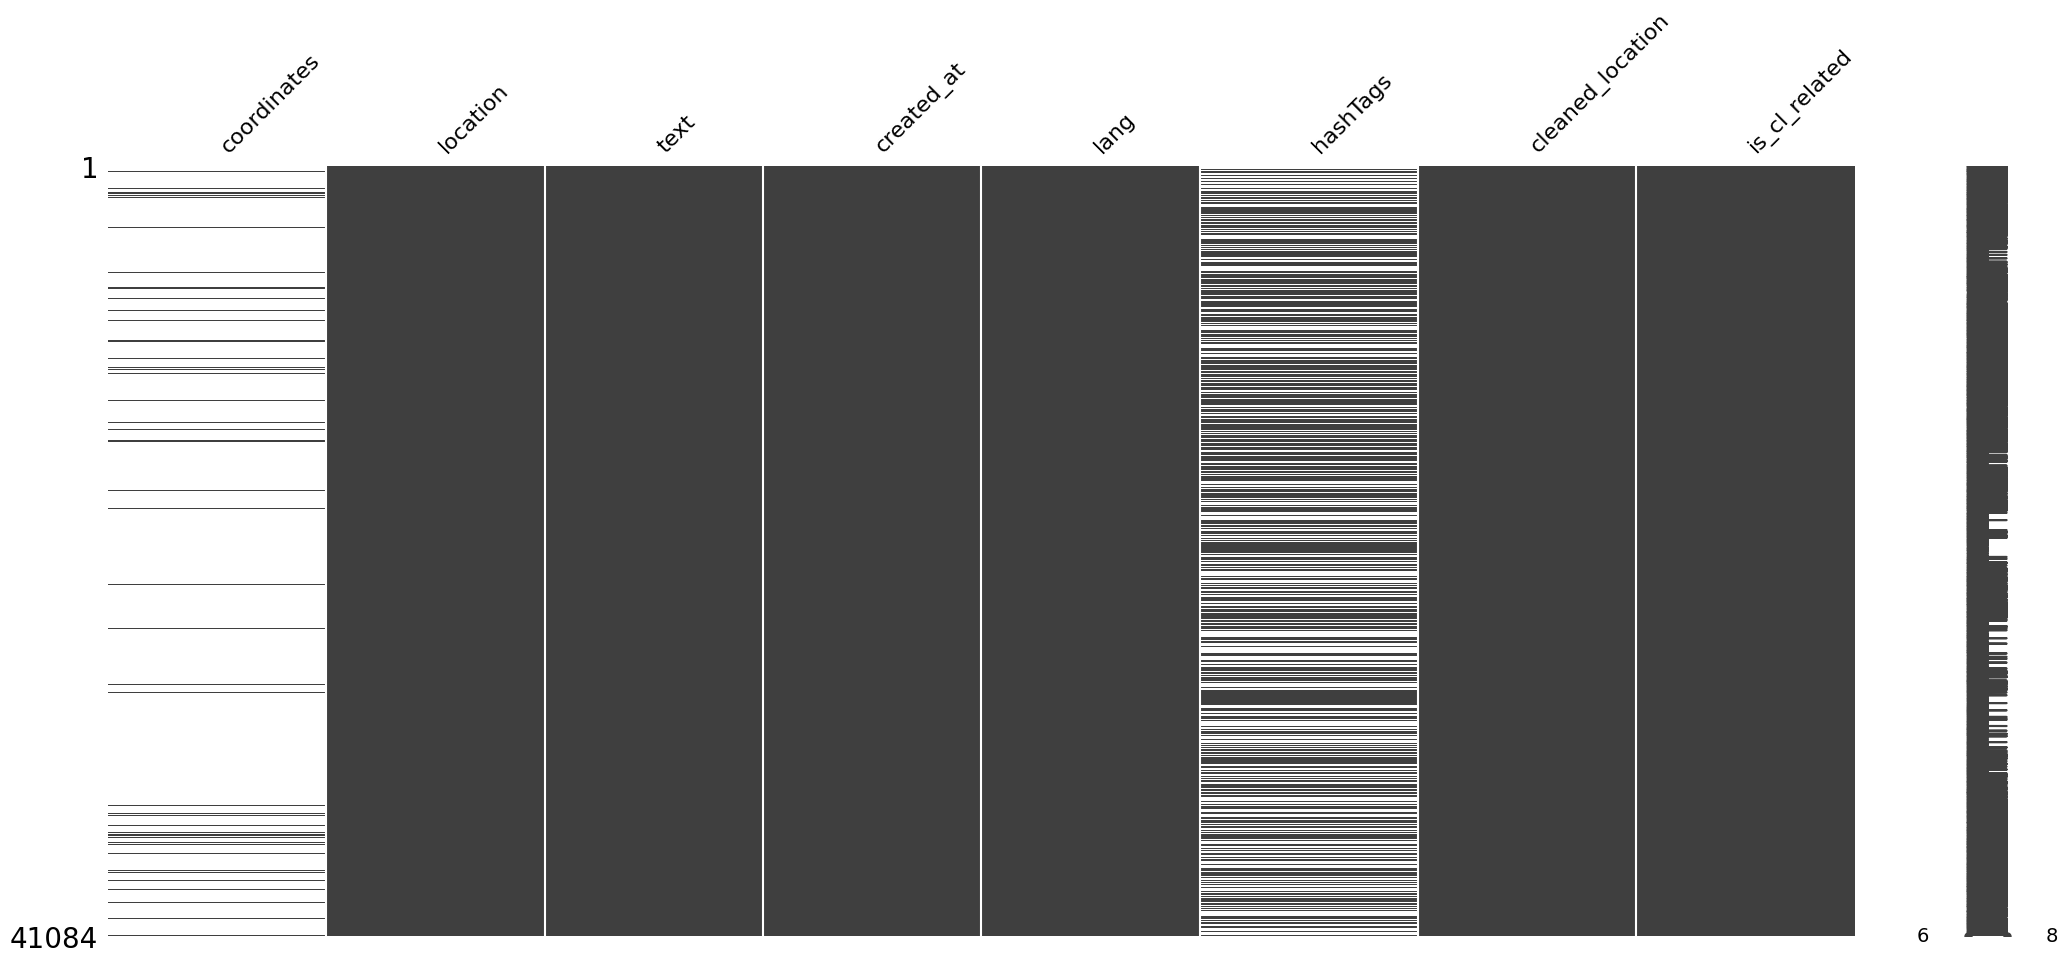

In [6]:
clean_df
msno.matrix(clean_df)

需要从cleaned_location获取坐标的行数: 10907
唯一cleaned_location数量: 3773
开始多线程地理编码...


地理编码位置:  56%|█████▋    | 2129/3773 [35:28<26:56,  1.02it/s] RateLimiter caught an error, retrying (0/2 tries). Called with (*('////\\\\\\\\',), **{'exactly_one': True, 'timeout': 10}).
Traceback (most recent call last):
  File "/home/ys_tum/miniconda3/envs/carto/lib/python3.8/site-packages/geopy/geocoders/base.py", line 368, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "/home/ys_tum/miniconda3/envs/carto/lib/python3.8/site-packages/geopy/adapters.py", line 472, in get_json
    resp = self._request(url, timeout=timeout, headers=headers)
  File "/home/ys_tum/miniconda3/envs/carto/lib/python3.8/site-packages/geopy/adapters.py", line 500, in _request
    raise AdapterHTTPError(
geopy.adapters.AdapterHTTPError: Non-successful status code 500

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ys_tum/miniconda3/envs/carto/lib/python3.8/site-packages/geopy/extra/rate_l

移除地理编码失败的行: 1169行
成功填充坐标的行数: 9738/10907 (89.28%)


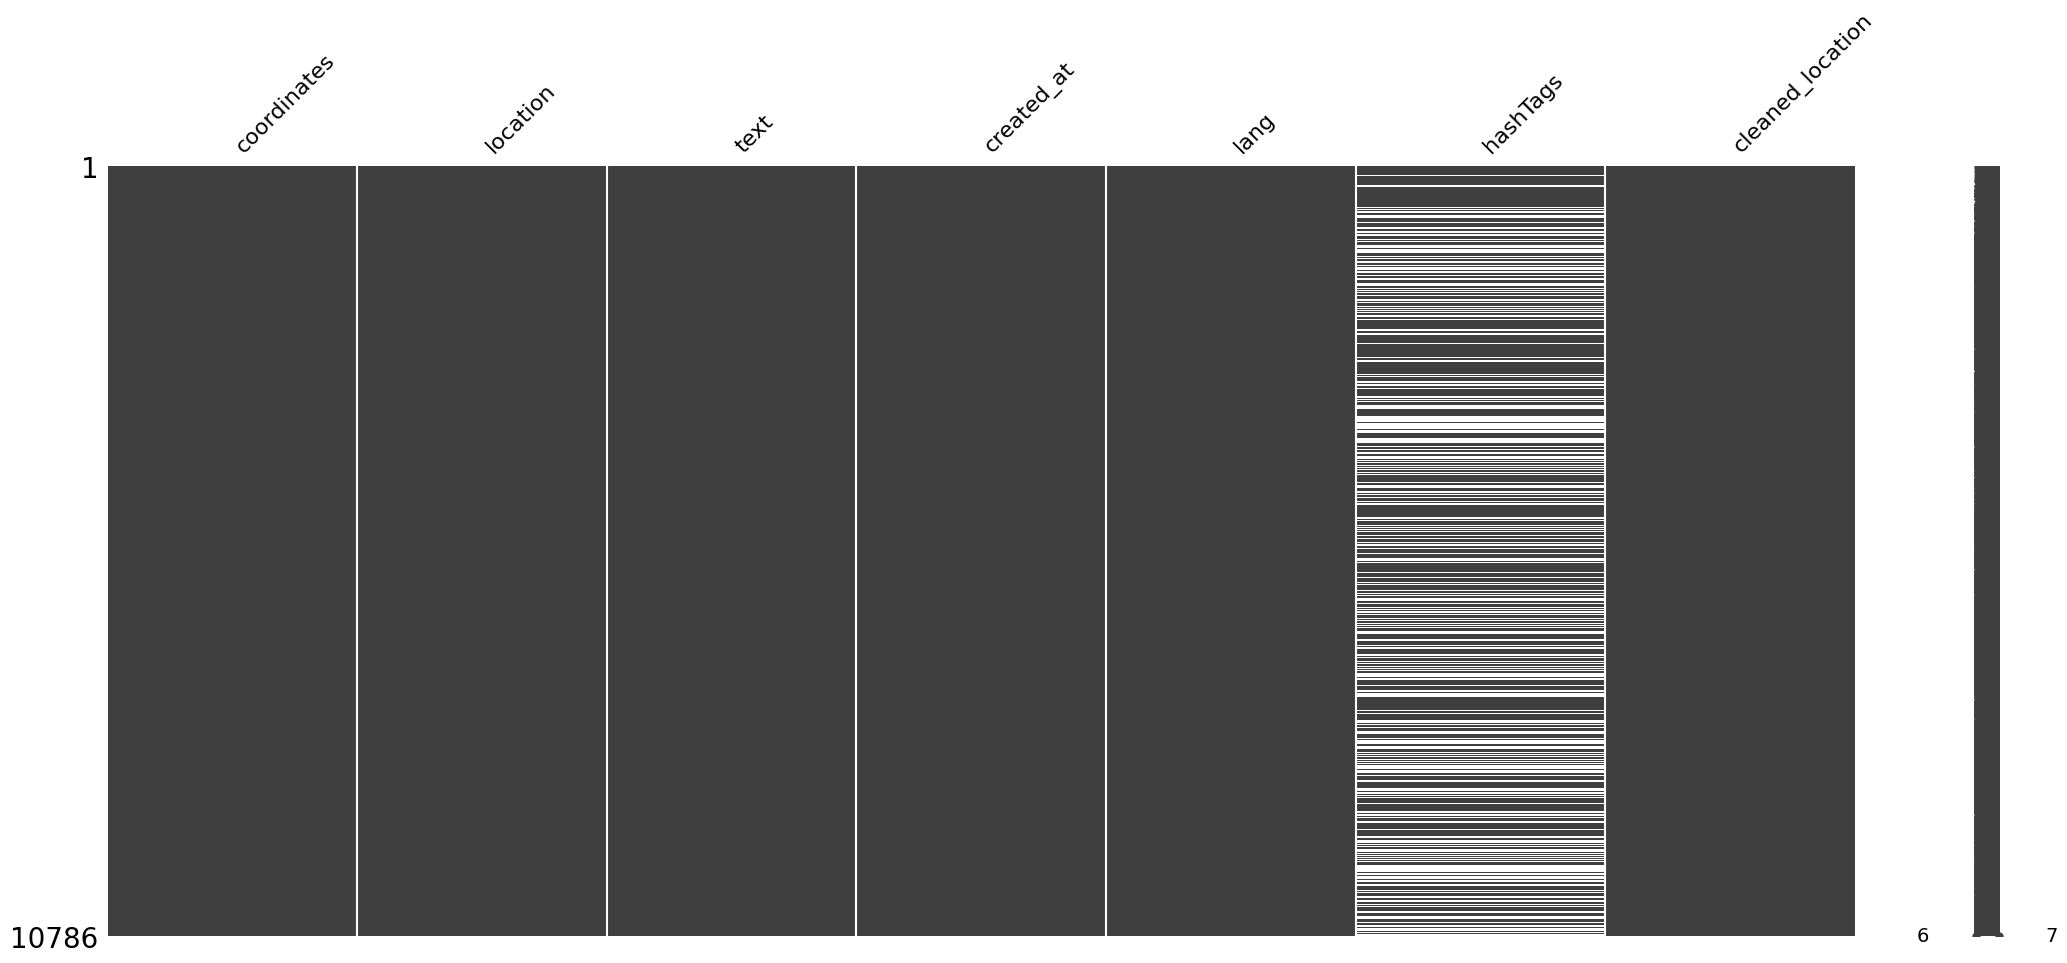

In [4]:
from geopy.geocoders import Nominatim
import pandas as pd
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from geopy.extra.rate_limiter import RateLimiter

def fill_missing_coordinates(df, max_workers=3):
    """
    多线程版本的地理编码函数
    
    参数:
    df: 包含cleaned_location和coordinates列的DataFrame
    max_workers: 线程池最大工作线程数
    
    返回:
    添加了经纬度的DataFrame
    """
    geolocator = Nominatim(user_agent="twitter_vgi_app")
    geocode = RateLimiter(geolocator.geocode)
    
    location_cache = {}
    failed_indices = set()
    missing_coords_mask = df['coordinates'].isna() & df['cleaned_location'].notna() & df['cleaned_location'].ne('')
    missing_coords_df = df[missing_coords_mask].copy()
    print(f"需要从cleaned_location获取坐标的行数: {len(missing_coords_df)}")
    unique_locations = list(missing_coords_df['cleaned_location'].unique())
    print(f"唯一cleaned_location数量: {len(unique_locations)}")

    def geocode_location(location):
        if isinstance(location, str) and location.strip():
            try:
                geocode_result = geocode(location, exactly_one=True, timeout=10)
                if geocode_result:
                    return location, f"{geocode_result.latitude},{geocode_result.longitude}"
                else:
                    return location, None
            except Exception as e:
                print(f"位置'{location}'地理编码错误: {e}")
                return location, None
        return location, None
    
    print("开始多线程地理编码...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 将任务提交到线程池并跟踪进度
        future_to_location = {executor.submit(geocode_location, loc): loc for loc in unique_locations}
        
        # 处理完成的任务结果
        for future in tqdm(future_to_location, desc="地理编码位置"):
            location = future_to_location[future]
            try:
                result_location, coords = future.result()
                location_cache[result_location] = coords
            except Exception as e:
                print(f"处理位置'{location}'时发生错误: {e}")
    
    for idx in tqdm(missing_coords_df.index, desc="更新坐标"):
        location = missing_coords_df.loc[idx, 'cleaned_location']
        if location in location_cache and location_cache[location]:
            df.loc[idx, 'coordinates'] = location_cache[location]
        else:
            failed_indices.add(idx)

    if failed_indices:
        print(f"移除地理编码失败的行: {len(failed_indices)}行")
        df = df.drop(index=failed_indices)
    
    # 统计结果
    filled_count = sum(df.loc[missing_coords_mask, 'coordinates'].notna())
    original_count = len(missing_coords_df)
    success_rate = (filled_count/original_count)*100 if original_count > 0 else 0
    print(f"成功填充坐标的行数: {filled_count}/{original_count} ({success_rate:.2f}%)")
    
    return df

geo_df = fill_missing_coordinates(clean_df)
geo_df
msno.matrix(geo_df)
geo_df.to_csv('./data/geo_Tennis_tweets.csv', index=False, encoding='utf-8')
